# Auto-Encoder Model


In [1]:
# Mounting the Google drive for loading the data and saving the model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
import cv2

import zipfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# https://drive.google.com/file/d/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri/view?usp=sharing

# Unzipping the images into drive.

with zipfile.ZipFile("/content/drive/My Drive/dataset.zip","r") as zip_ref:
  zip_ref.extractall()

In [4]:
from PIL import Image
import os
import shutil

data = []
# Taking the files into a list with path names for image retrieval.
path = 'dataset/'
for i in os.listdir(path = path):
  data.append(path + str(i))

print(len(data))

4738


In [5]:
# checking sample files which are in jpg format
data[:5]

['dataset/3064.jpg',
 'dataset/2195.jpg',
 'dataset/4366.jpg',
 'dataset/1748.jpg',
 'dataset/3803.jpg']

In [6]:
# We check the max and min shape of data
width=[]
height=[]

for i in data:
  j = plt.imread(i)
  w, h, channel = j.shape
  width.append(w)
  height.append(h)

# we find the width and height of images are same
print('Max Width: ', max(width))
print('Min Width: ', min(width))
print('Max Height: ', max(height))
print('Min Height: ', min(height))

Max Width:  512
Min Width:  512
Max Height:  512
Min Height:  512


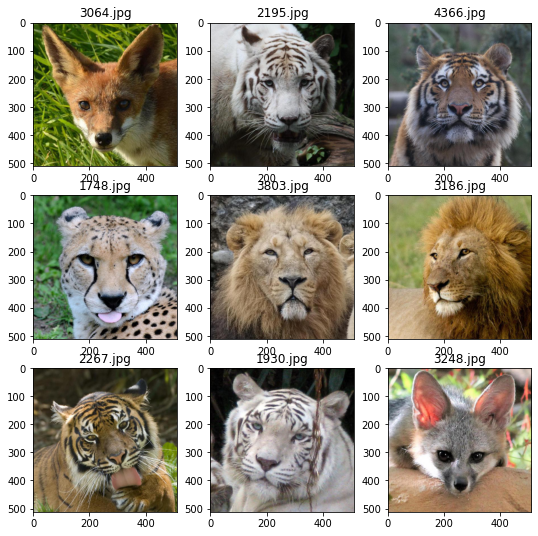

In [7]:
# Checking the sample images

plt.figure(figsize= (9, 9))
for i in range(9):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(3, 3, i + 1)
  img = plt.imread(data[i])
  plt.imshow(img)
  j = data[i]
  plt.title(j[len(path):])

plt.show()

## Creating the dataset for Train and Test
* The images are 512 x 512 size of RGB.
* Considered all images  inspite of constraint because to find the images are balanced or unbalanced is a tough task as this is unsupervised.
* Due to colab RAM constraints I resized images to 256 x 256.
* Tried resizing between 512 and 256 but RAM crashes and 256 is considered.
* Also tried gray scale images but due to vectors taken out of encoder part, the size remains same, hence dropped the idea.
* Almost 95% of data is used for train and 2.5% for validation/cv and 2.5% for test.



In [10]:
# Function to load the images with the below changes.

def load_images(path):
  image_list = []
  # the data with image path is provided in 'path'
  for i in path:
    img = cv2.imread(i)
    # resize the image from 512 x 512 to 256 x 256
    img = cv2.resize(img, (256, 256))
    # cv2 reads image in BGR so we convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Image Normalizing for easy gradient descent as it takes less time for convergence 
    img = img/255.
    # finally after changes to each image , we append it to a list.
    image_list.append(img)
  return image_list

In [11]:
# convert the list to numpy array for Train data 'y' label
train_array = load_images(data[:4480])
train_array = np.array(train_array)
train_array.shape

(4480, 256, 256, 3)

In [12]:
# convert the list to numpy array for Test data 'y' label
test_array = load_images(data[4480:4736])
test_array = np.array(test_array)
test_array.shape

(256, 256, 256, 3)

## Gaussian Speckle
* The images for 'x' label are gaussian noise (speckle)
* The images are speckled using below function and the output can be seen.

In [13]:
# https://stackoverflow.com/a/27342545

def load_images_speckle(path):
  image_list = []
  for i in path:
    image = cv2.cvtColor(cv2.imread(i), code = cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    row,col,ch = image.shape
    # random row / width, col / height and channel are chosen
    gauss = np.random.randn(row,col,ch, )
    gauss = gauss.reshape(row,col,ch)
    # speckle created by multiplying the gauss shape matrix with image matrix and then finally adding them.
    speckle = image + image * gauss
    speckle = speckle/255.
    image_list.append(speckle)
  return image_list
  

In [14]:
# convert the list to numpy array for Train data 'X' label

train_array_speckle = load_images_speckle(data[:4480])
train_array_speckle = np.array(train_array_speckle)
train_array_speckle.shape

(4480, 256, 256, 3)

In [15]:
# convert the list to numpy array for Test data 'X' label

test_array_speckle = load_images_speckle(data[4480:4736])
test_array_speckle = np.array(test_array_speckle)
test_array_speckle.shape

(256, 256, 256, 3)

## Sample Speckle image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


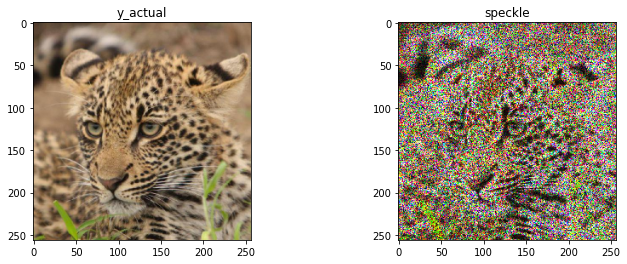

In [16]:
# original image
y_actual = test_array[0:1]
y_actual = np.reshape(y_actual , (y_actual.shape[1], y_actual.shape[2], y_actual.shape[3]))

# speckle image
speckle = np.reshape(test_array_speckle[0:1], 
                     (test_array_speckle[0:1].shape[1], test_array_speckle[0:1].shape[2], test_array_speckle[0:1].shape[3]))


plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(y_actual)
plt.title('y_actual')
plt.subplot(1,2,2)
plt.imshow(speckle)
plt.title('speckle')
plt.show()

## Auto-Encoder Model
### Task
* The task is to pass a speckled image ('X' label) through the model and to denoise the image.
* The model consists of two parts. Encoder and Decoder.
* The Encoder takes the image as input and the extracts the features at the bottom and hence important features are learnt through back propagation and noise is discarded.
* The Decoder collects the features from bottom of Encoder and then reconstructs the image to is original shape, thus denoising the image.

### Architecture
* Conv layer with kernel size of 3x3 and various number of filters such as 128, 64 are used and filters decrease as we go down the end of Encoder.
* Batch Norm Layer is used to keep the distribution of gradients in normal during back propagation.                 
* Dropout Layer is used to reduce overfitting and prob rate of 0.3 suited well after various hyperparam tuning.
* The Upsampling Layer is used to reconstruct the image by repeating the rows and columns of the data by size[0] and size[1] and is a part of Decoder.


In [17]:
#Encoder
model= Sequential()
model.add(Conv2D(filters= 128, kernel_size= (3,3), activation='relu', padding='same', name='ENconv1', kernel_initializer='he_uniform',
                 input_shape = (256, 256, 3)))
model.add(BatchNormalization(name= 'BN1'))
model.add(Dropout(rate = 0.3))
model.add(MaxPooling2D((2,2), padding='same', name='MPool1'))
model.add(Conv2D(filters= 64, kernel_size= (3,3), activation='relu', padding='same', name='ENconv2', kernel_initializer='he_uniform'))
model.add(BatchNormalization(name= 'BN2'))
model.add(Dropout(rate = 0.3))
model.add(MaxPooling2D((2,2), padding='same', name='MPool2'))

#Decoder
model.add(Conv2D(filters= 64, kernel_size= (3,3), activation='relu', padding='same', name='DEconv1', kernel_initializer='he_uniform'))
model.add(UpSampling2D((2,2), name='UPsample1'))
model.add(Conv2D(filters= 128, kernel_size= (3,3), activation='relu', padding='same', name='DEconv2', kernel_initializer='he_uniform'))
model.add(UpSampling2D((2,2), name='UPsample2'))
model.add(Conv2D(filters= 3, kernel_size= (3,3), activation='sigmoid', padding='same', name='DEconv3', kernel_initializer='he_uniform'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ENconv1 (Conv2D)             (None, 256, 256, 128)     3584      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 256, 256, 128)     512       
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 128)     0         
_________________________________________________________________
MPool1 (MaxPooling2D)        (None, 128, 128, 128)     0         
_________________________________________________________________
ENconv2 (Conv2D)             (None, 128, 128, 64)      73792     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 128, 128, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0

## Model Compile & Fit
* The optimizer is Adam and it works best when the kernel initializer of Conv2D is 'he_uniform'.
* the loss function is 'mean squared error' and we need to decrease the loss through back prop.
* Number of epochs are 10 and batches are 560, 8 images per batch.
* The 'y' label are original images and 'x' label are speckled images.

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam')
epochs = 10
batches = 8

In [19]:
history = model.fit(x = train_array_speckle, y = train_array, batch_size= batches, epochs= epochs, 
                    validation_data= (test_array_speckle[:128], test_array[:128]))

Epoch 1/10
560/560 [==============================] - 36s 64ms/step - loss: 0.0102 - val_loss: 0.0145
Epoch 2/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0066 - val_loss: 0.0165
Epoch 3/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0061 - val_loss: 0.0262
Epoch 4/10
560/560 [==============================] - 36s 63ms/step - loss: 0.0058 - val_loss: 0.0244
Epoch 5/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0055 - val_loss: 0.0199
Epoch 6/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0053 - val_loss: 0.0200
Epoch 7/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0053 - val_loss: 0.0179
Epoch 8/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0050 - val_loss: 0.0125
Epoch 9/10
560/560 [==============================] - 35s 63ms/step - loss: 0.0050 - val_loss: 0.0256
Epoch 10/10
560/560 [==============================] - 35s 63ms/step - loss: 0.004

In [20]:
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, color = 'b'):
  ax.plot(x, vy, 'b', label = 'Validation Loss')
  ax.plot(x, ty, 'r', label = 'Train Loss')
  plt.grid()
  plt.legend()
  fig.canvas.draw()

## Model Evaluation and Prediction
* We can see the loss is 0.02 which is ver low.
* We tried to avoid overfitting.
* The predictions are also very satisfying.

4/4 [==============================] - 0s 53ms/step - loss: 0.0250
Test Score:  0.024956010282039642


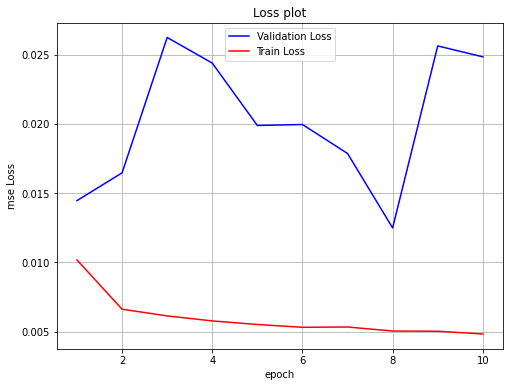

In [21]:
score = model.evaluate(x = test_array_speckle[128:], y = test_array[128:])
print('Test Score: ', score)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.set_xlabel('epoch')
ax.set_ylabel('mse Loss')
plt.title('Loss plot')

# list of epoch numbers: epoch = 5
x = list(range(1, epochs + 1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


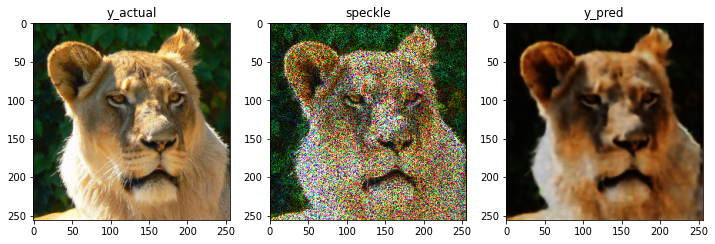

In [22]:
# original image
y_actual = test_array[128:129]
y_actual = np.reshape(y_actual , (y_actual.shape[1], y_actual.shape[2], y_actual.shape[3]))

# speckle image
speckle = np.reshape(test_array_speckle[128:129], 
                     (test_array_speckle[128:129].shape[1], test_array_speckle[128:129].shape[2], test_array_speckle[128:129].shape[3]))

# predicted image
y_pred = model.predict(x = test_array_speckle[128:129])
y_pred = np.reshape(y_pred , (y_pred.shape[1], y_pred.shape[2], y_pred.shape[3]))

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(y_actual)
plt.title('y_actual')
plt.subplot(1,3,2)
plt.imshow(speckle)
plt.title('speckle')
plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.title('y_pred')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


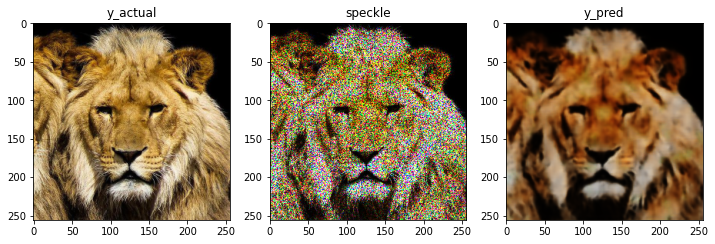

In [23]:
# original image
y_actual = test_array[129:130]
y_actual = np.reshape(y_actual , (y_actual.shape[1], y_actual.shape[2], y_actual.shape[3]))

# speckle image
speckle = np.reshape(test_array_speckle[129:130], 
                     (test_array_speckle[129:130].shape[1], test_array_speckle[129:130].shape[2], test_array_speckle[129:130].shape[3]))

# predicted image
y_pred = model.predict(x = test_array_speckle[129:130])
y_pred = np.reshape(y_pred , (y_pred.shape[1], y_pred.shape[2], y_pred.shape[3]))

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(y_actual)
plt.title('y_actual')
plt.subplot(1,3,2)
plt.imshow(speckle)
plt.title('speckle')
plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.title('y_pred')
plt.show()

## Model Save and Feature Extraction
* We saved the model and used in another notebook due to memory constraints.
* The feature is extracted from the end of Encoder in the model as shown below, which is used for clustering and providing similar image to the given input image.

In [24]:
model.save('/content/drive/My Drive/model3.h5')

In [30]:
model1 = Sequential()
model1.add(Model(model.input, model.layers[-6].output))
model1.add(Flatten())
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_7 (Functional)    (None, 64, 64, 64)        78144     
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
Total params: 78,144
Trainable params: 77,760
Non-trainable params: 384
_________________________________________________________________
